In [7]:
import sys
import os
import time
import numpy as np
np.random.seed(42)

import json
import tensorflow as tf

import matplotlib as mpl
from matplotlib import pyplot as plt
import matplotlib.lines as mlines
#%matplotlib notebook
#%matplotlib inline
%matplotlib notebook

import warnings
warnings.filterwarnings('ignore', module='numpy')
warnings.filterwarnings('ignore')

import importlib
git_dir = os.path.join(os.path.expanduser('~'), 'git', 'nh3-analysis')
src_dir = os.path.join(os.path.expanduser('~'), 'git', 'time-resolved-nr', 'src')
sys.path.append(src_dir)

from stable_baselines3 import PPO, SAC
from stable_baselines3.common.callbacks import CheckpointCallback


In [67]:
import rl_model
importlib.reload(rl_model)

initial_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201282-expt.json')
final_state_expt_file = os.path.join(git_dir, 'jan2023', 'dyn-fitting', '201290-expt.json')

data_file = os.path.join(git_dir, 'jan2023', 'data', 'r201289-time-resolved.json')


REVERSE = True
MIXING = False
MAX_TIME = 30

with open(data_file) as fd:
    m = json.load(fd)
    timestamps = np.asarray(m['times'][:MAX_TIME])
    _data = m['data'][:MAX_TIME]
    print("Number of times: %s" % len(_data))
print(timestamps)

# create an instance of our custom environment
env = rl_model.SLDEnv(initial_state_file=initial_state_expt_file,
                      final_state_file=final_state_expt_file,
                      data=_data[:MAX_TIME], reverse=REVERSE, allow_mixing=MIXING)

# use the Gymnasium 'check_env' function to check the environment
# - returns nothing if the environment is verified as ok
from gymnasium.utils.env_checker import check_env
check_env(env)

# initialize the environment
env.reset()
env.render()



Number of times: 30
[  0  15  30  45  60  75  90 105 120 135 150 165 180 195 210 225 240 255
 270 285 300 315 330 345 360 375 390 405 420 435]
0


skip: .DS_Store


<IPython.core.display.Javascript object>


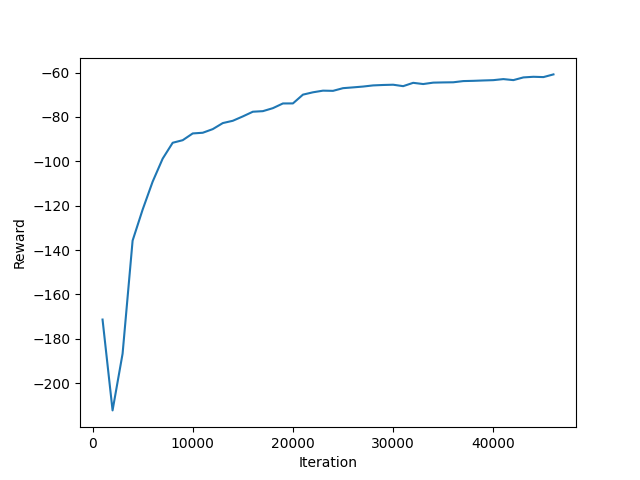

In [74]:
log_dir = "./logs-201289-fwd/"


_dir_list = os.listdir(log_dir)

def evaluate(model):
    episode_reward = 0
    n_times = len(env.data)
    obs, info = env.reset()

    chi2 = 0
    time_chi2 = []
    
    for i in range(MAX_TIME):
        action, _ = model.predict(obs, deterministic=True)
        chi2 += env.chi2
        obs, reward, terminated, truncated, info = env.step(action)  
        episode_reward += reward
        time_chi2.append(reward)

    return episode_reward, time_chi2

itr_list = []
reward_list = []
time_chi2_list = []
models = []

for file in _dir_list:
    try:
        model = SAC.load(os.path.join(log_dir, file))
        reward, time_chi2 = evaluate(model)
        iteration = int(file.replace("rl_model_", "").replace("_steps.zip", ""))
        itr_list.append(iteration)
        reward_list.append(reward)
        time_chi2_list.append(time_chi2)
        models.append(model)
    except:
        print("skip: %s" % file)


time_chi2_list = np.asarray(time_chi2_list)
itr_list = np.asarray(itr_list)
reward_list = np.asarray(reward_list)
idx = itr_list.argsort()

fig = plt.figure(dpi=100)
plt.plot(itr_list[idx], reward_list[idx])
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.show()

(46, 30)
46000


<IPython.core.display.Javascript object>


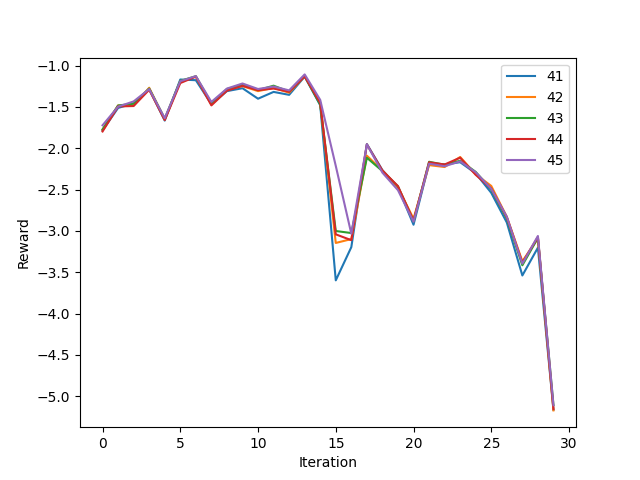

In [75]:
print(time_chi2_list.shape)
print(itr_list[idx][-1])

fig = plt.figure(dpi=100)

for i in range(len(time_chi2_list)-5, len(time_chi2_list)):   
    plt.plot(np.arange(time_chi2_list.shape[1]), time_chi2_list[idx][i], label=str(i))
plt.xlabel('Iteration')
plt.ylabel('Reward')
plt.legend()
plt.show()

In [70]:
# Evaluate the agent
#Nature catalyssiis 2 1055 2019

model = models[idx[-1]]
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

times = []
actions = []
chi2 = []
for i in range(n_times):
    action, _ = model.predict(obs, deterministic=True)
    actions.append(action)
    times.append(timestamps[env.time_stamp])
    _time = timestamps[env.time_stamp]
    new_obs, reward, terminated, truncated, info = env.step(action)  
    chi2.append(env.chi2)
    episode_reward += reward
    print("Time %s %s: %g [%s] %g" % (_time, obs, reward, terminated, episode_reward))
    obs = new_obs


actions = np.asarray(actions)
chi2 = np.asarray(chi2)
times = np.asarray(times)
print(times)

Number of times: 30
Time 435 [1.]: -1.83522 [False] -1.83522
Time 420 [0.9655172]: -1.50358 [False] -3.3388
Time 405 [0.9310345]: -1.47239 [False] -4.81119
Time 390 [0.8965517]: -1.29028 [False] -6.10147
Time 375 [0.86206895]: -1.67763 [False] -7.7791
Time 360 [0.82758623]: -1.19316 [False] -8.97226
Time 345 [0.79310346]: -1.1921 [False] -10.1644
Time 330 [0.7586207]: -1.446 [False] -11.6104
Time 315 [0.7241379]: -1.30149 [False] -12.9119
Time 300 [0.6896552]: -1.26278 [False] -14.1746
Time 285 [0.6551724]: -1.38293 [False] -15.5576
Time 270 [0.62068963]: -1.27493 [False] -16.8325
Time 255 [0.5862069]: -1.3625 [False] -18.195
Time 240 [0.55172414]: -1.14339 [False] -19.3384
Time 225 [0.51724136]: -1.47487 [False] -20.8133
Time 210 [0.4827586]: -3.40093 [False] -24.2142
Time 195 [0.44827586]: -3.17081 [False] -27.385
Time 180 [0.41379312]: -1.96621 [False] -29.3512
Time 165 [0.37931034]: -2.27442 [False] -31.6256
Time 150 [0.3448276]: -2.51193 [False] -34.1376
Time 135 [0.31034482]: -2.

In [71]:
deltas = env.high_array - env.low_array

samples = []
mixing = []

for n in range(100):
    actions = []
    obs, info = env.reset()
    for i in range(len(env.data)):
        action, _ = model.predict(obs, deterministic=False)
        obs, reward, terminated, truncated, info = env.step(action)
        actions.append(action)
    
    actions = np.asarray(actions)
    values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0
    samples.append(values)

    if MIXING:
        mixing.append((1+actions[:,-1]) / 2.0)


samples = np.asarray(samples).T
mixing = np.asarray(mixing).T
print(samples.shape)

errs = np.std(samples, axis=2)
print(errs.shape)

if MIXING:
    mixing_err = np.std(mixing, axis=1)
    print(mixing_err.shape)

(7, 30, 100)
(7, 30)


<IPython.core.display.Javascript object>


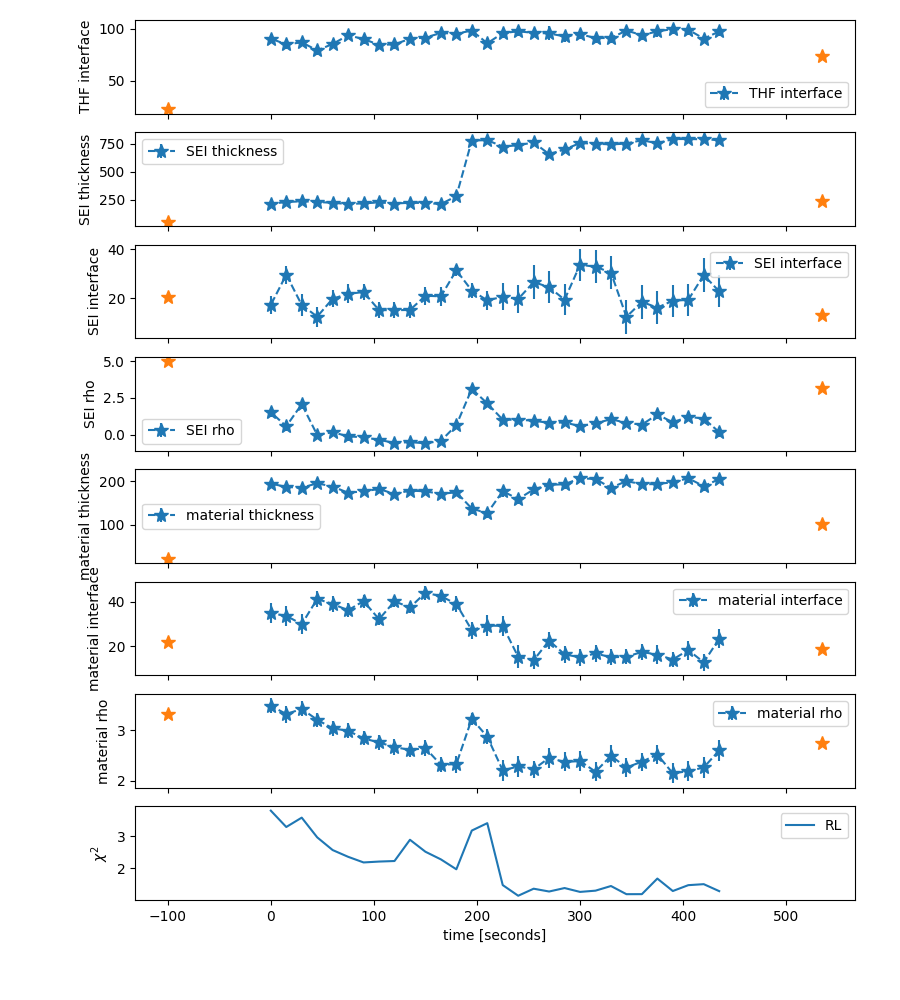

['THF interface', 'SEI thickness', 'SEI interface', 'SEI rho', 'material thickness', 'material interface', 'material rho']


Text(0.5, 0, 'time [seconds]')

In [72]:
deltas = env.high_array - env.low_array
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0

pars = values.T


t_delay = 100
if REVERSE:
    t_initial = timestamps[-1]+t_delay
    t_final = -t_delay
    _times = np.flip(timestamps)
else:
    t_final = timestamps[-1]+t_delay
    t_initial = -t_delay
    _times = timestamps

n_times = len(env.data)

n_plots = pars.shape[0]+1

fig, axs = plt.subplots(n_plots, 1, dpi=100, figsize=(9,10), sharex=True)
plt.subplots_adjust(left=0.15, right=.95, top=0.98, bottom=0.1)
        
print(env.par_labels)
for i in range(pars.shape[0]):
    ax = plt.subplot(n_plots, 1, i+1)
    
    plt.errorbar(_times, pars[i], yerr=errs[i], label=env.par_labels[i], linestyle='--', marker='*', markersize=10)


    plt.plot([t_initial, t_final], [env.parameters[i], env.end_parameters[i]], linestyle='', marker='*', markersize=10)
    
    plt.ylabel(env.par_labels[i])
    plt.legend()

i +=1
ax = plt.subplot(n_plots, 1, i+1)
plt.plot(_times, chi2, label = 'RL')
plt.legend()
plt.ylabel("$\chi^2$")
plt.xlabel("time [seconds]")

Number of times: 30


<IPython.core.display.Javascript object>


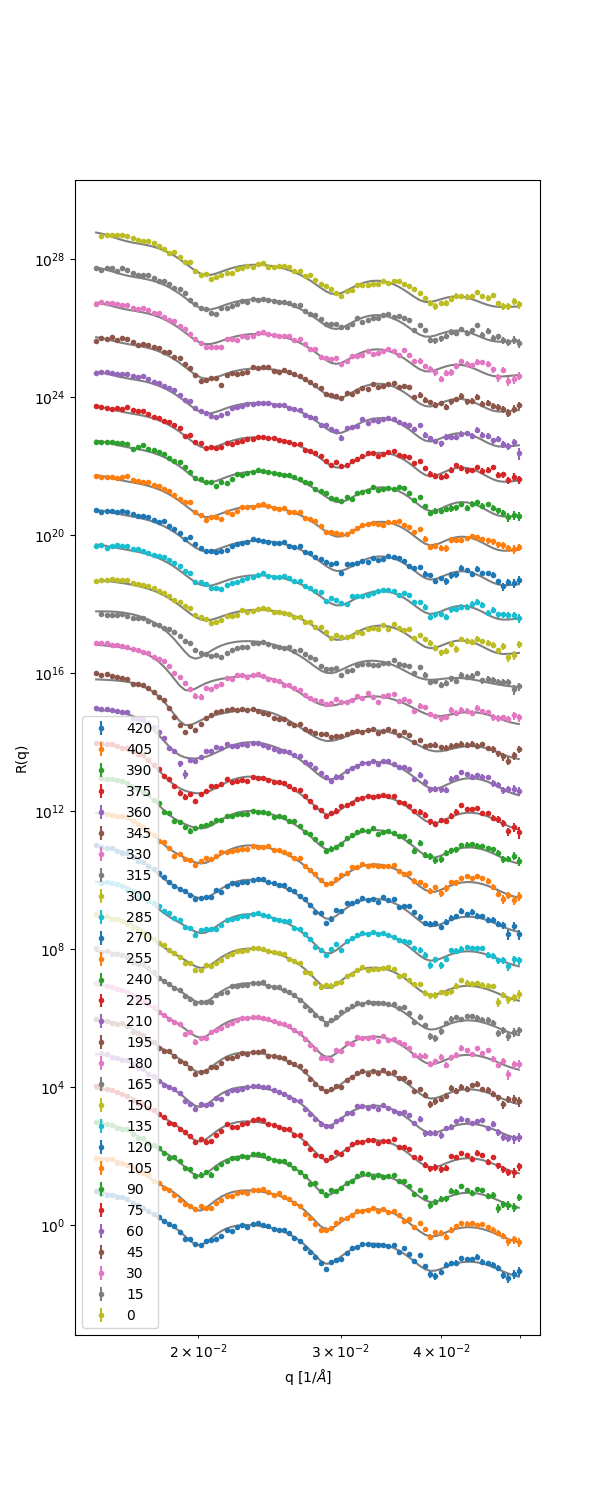

In [73]:
# Evaluate the agent
episode_reward = 0

n_times = len(env.data)
print("Number of times: %s" % n_times)

obs, info = env.reset()

fig = plt.subplots(dpi=100, figsize=(6, 15))
for i in range(1, n_times, 1):
    action, _ = model.predict(obs, deterministic=True)
    
    obs, reward, terminated, truncated, info = env.step(action)

    env.plot(scale=10.**i, newfig=False, errors=True, label=times[i])


<IPython.core.display.Javascript object>


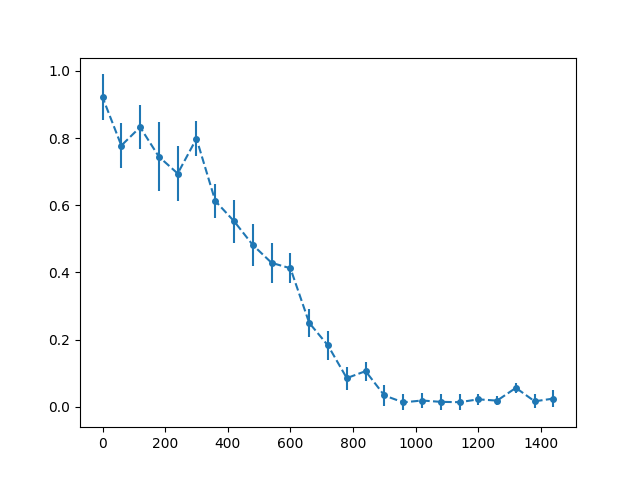

<ErrorbarContainer object of 3 artists>

In [27]:
actions = np.asarray(actions)
values = env.low_array + (1+actions[:,:len(env.parameters)]) * deltas / 2.0


mixing = (actions[:,-1] + 1)/2.0


fig = plt.subplots(dpi=100, )

plt.errorbar(times, mixing, yerr=mixing_err, label='Bayesian fit [forward]', marker='.', markersize=8, linestyle='--')
 
